# CNN with Bidirctional RNN - Char Classification
Using TensorFlow

## TODO
```
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import cv2


%matplotlib notebook
# Increase size of plots
plt.rcParams['figure.figsize'] = (9.0, 5.0)


# Helpers
from ocr.helpers import implt
from ocr.mlhelpers import TrainingPlot, DataSet
from ocr.imgtransform import coordinates_remap
from ocr.datahelpers import loadGapData, correspondingShuffle
from ocr.tfhelpers import Graph, create_cell

tf.reset_default_graph()
sess = tf.InteractiveSession()

print("OpenCV: " + cv2.__version__)
print("Numpy: " + np.__version__)
print("TensorFlow: " + tf.__version__)

OpenCV: 3.1.0
Numpy: 1.13.1
TensorFlow: 1.3.0


## Settings

In [2]:
PAD = 0                            # Value for PADding images
POS = 1                            # Values of positive and negative label 0/-1
NEG = 0

POS_SPAN = 1                             # Number of positive values around true position (5 is too high)
POS_WEIGHT = 3                           # Weighting possitive values in loss counting

slider_size = (60, 60)                   # Height is set to 60 by data and width should be even
N_INPUT = slider_size[0]*slider_size[1]  # Size of sequence input vector will depend on CNN
num_buckets = 5
n_classes = 2                            # Number of different outputs

rnn_layers = 4
rnn_residual_layers = 2                  # HAVE TO be smaller than encoder_layers
rnn_units = 256

learning_rate = 1e-4
dropout = 0.4                            # Percentage of dopped out data
train_set = 0.8                          # Percentage of training data

TRAIN_STEPS = 500000                     # Number of training steps!
TEST_ITER = 150
LOSS_ITER = 50
SAVE_ITER = 2000
BATCH_SIZE = 10
# EPOCH = 2000                           # "Number" of batches in epoch

save_loc = 'models/gap-clas/RNN/Bi-RNN-dense'

## Loading Images

In [3]:
images_seq, labels_seq = loadGapData('data/gapdet/large/',
                                     slider=slider_size,
                                     seq=True)

Loading gap data...
-> Number of words / gaps and letters: 168 / 13591


## Dataset

In [4]:
# Shuffle data
images_seq, labels_seq = correspondingShuffle([images_seq, labels_seq])

    
# Split data on train and test dataset
div = int(train_set * len(images_seq))

trainImages = images_seq[0:div]
testImages = images_seq[div:]

trainLabels = labels_seq[0:div]
testLabels = labels_seq[div:]

print("Training images:", div)
print("Testing images:", len(images_seq) - div)

Training images: 134
Testing images: 34


In [5]:
class BucketDataIterator():
    """ Iterator for feeding seq2seq model during training """
    def __init__(self,
                 images,
                 targets,
                 num_buckets=5,
                 train=True):
        
        self.train = train
        length = [len(seq) for seq in images]  

        # Create pandas dataFrame and sort it by images seq lenght (length) 
        # in_length == out_length
        self.dataFrame = pd.DataFrame({'length': length,
                                       'images': images,
                                       'targets': targets
                                      }).sort_values('length').reset_index(drop=True)

        bsize = int(len(images) / num_buckets)
        self.num_buckets = num_buckets
        
        # Create buckets by slicing parts by indexes
        self.buckets = []
        for bucket in range(num_buckets-1):
            self.buckets.append(self.dataFrame.iloc[bucket * bsize: (bucket+1) * bsize])
        self.buckets.append(self.dataFrame.iloc[(num_buckets-1) * bsize:])        
        
        self.buckets_size = [len(bucket) for bucket in self.buckets]

        # cursor[i] will be the cursor for the ith bucket
        self.cursor = np.array([0] * num_buckets)
        self.bucket_order = np.random.permutation(num_buckets)
        self.bucket_cursor = 0
        self.shuffle()
        print("Iterator created.")


    def shuffle(self, idx=None):
        """ Shuffle idx bucket or each bucket separately """
        for i in [idx] if idx is not None else range(self.num_buckets):
            self.buckets[i] = self.buckets[i].sample(frac=1).reset_index(drop=True)
            self.cursor[i] = 0


    def next_batch(self, batch_size):
        """
        Creates next training batch of size: batch_size
        Retruns: image seq, letter seq, seq lengths
        """
        i_bucket = self.bucket_order[self.bucket_cursor]
        # Increment cursor and shuffle in case of new round
        self.bucket_cursor = (self.bucket_cursor + 1) % self.num_buckets
        if self.bucket_cursor == 0:
            self.bucket_order = np.random.permutation(self.num_buckets)
            
        if self.cursor[i_bucket] + batch_size > self.buckets_size[i_bucket]:
            self.shuffle(i_bucket)

        # Handle too big batch sizes
        if (batch_size > self.buckets_size[i_bucket]):
            batch_size = self.buckets_size[i_bucket]

        res = self.buckets[i_bucket].iloc[self.cursor[i_bucket]:
                                          self.cursor[i_bucket]+batch_size]
        self.cursor[i_bucket] += batch_size

        # PAD input sequence and output
        # Pad sequences with <PAD> to same length
        max_length = max(res['length'])
        
        input_seq = np.zeros((batch_size, max_length, N_INPUT), dtype=np.float32)
        for i, img in enumerate(res['images']):
            input_seq[i][:res['length'].values[i]] = img
        
        # Need to pad according to the maximum length output sequence
        targets = np.ones([batch_size, max_length], dtype=np.float32) * PAD
        for i, target in enumerate(targets):
            target[:res['length'].values[i]] = res['targets'].values[i]
        
        return input_seq, targets, res['length'].values


    def next_feed(self, size):
        """ Create feed directly for model training """
        (inputs_,
         targets_,
         length_) = self.next_batch(size)
        return {
            inputs: inputs_,            
            targets: targets_,
            length: length_,
            keep_prob: (1.0 - dropout) if self.train else 1.0
        }

In [6]:
# Create iterator for feeding BiRNN
train_iterator = BucketDataIterator(trainImages,
                                    trainLabels,
                                    num_buckets,
                                    train=True)
test_iterator = BucketDataIterator(testImages,
                                   testLabels,
                                   1,
                                   train=False)

Iterator created.
Iterator created.


# Create classifier

## Inputs

In [7]:
# Input placehodlers
# N_INPUT -> size of vector representing one image in sequence
# Inputs shape (batch_size, max_seq_length, vec_size) - time major
inputs = tf.placeholder(shape=(None, None, N_INPUT),
                                dtype=tf.float32,
                                name='inputs')
length = tf.placeholder(shape=(None,),
                        dtype=tf.int32,
                        name='length')
# Required for training, not required for application
targets = tf.placeholder(shape=(None, None),
                         dtype=tf.int64,
                         name='targets')
# Dropout value
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

## Standardization + CNN

In [8]:
# Help functions for standard layers
def conv2d(x, W, name=None):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name=name)

def max_pool_2x2(x, name=None):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

# 1. Layer - Convulation variables
W_conv1 = tf.get_variable('W_conv1', shape=[5, 5, 1, 2],
                          initializer=tf.contrib.layers.xavier_initializer())
b_conv1 = tf.Variable(tf.constant(0.1, shape=[2]), name='b_conv1')
# 3. Layer - Convulation variables
W_conv2 = tf.get_variable('W_conv2', shape=[5, 5, 2, 4],
                          initializer=tf.contrib.layers.xavier_initializer())
b_conv2 = tf.Variable(tf.constant(0.1, shape=[4]), name='b_conv2')

def CNN(x):
    x = tf.image.per_image_standardization(x)
    x = tf.reshape(x, [1, slider_size[0], slider_size[1], 1])
    # 1. Layer - Convulation
    h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1, name='h_conv1')
    # 2. Layer - Max Pool
    h_pool1 = max_pool_2x2(h_conv1, name='h_pool1')
    # 3. Layer - Convulation
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2, name='h_conv2')
    # 4. Layer - Max Pool
    return max_pool_2x2(h_conv2, name='h_pool2')

# Input images CNN
inpts = tf.map_fn(
    lambda seq: tf.map_fn(
        lambda img:
            tf.reshape(
                CNN(tf.reshape(img, [slider_size[0], slider_size[1], 1])),
#                 CNN(tf.reshape(img, [1, slider_size[0], slider_size[1], 1])),
                [-1]),
        seq),
    inputs,
    dtype=tf.float32)

## Bi-RNN

In [9]:
# Cells
cell_fw = create_cell(rnn_units,
                      rnn_layers,
                      rnn_residual_layers,
                      is_dropout=True,
                      keep_prob=keep_prob)
cell_bw = create_cell(rnn_units,
                      rnn_layers,
                      rnn_residual_layers,
                      is_dropout=True,
                      keep_prob=keep_prob)

In [10]:
# Bidirectional RNN
bi_outputs, _ = tf.nn.bidirectional_dynamic_rnn(
    cell_fw = cell_fw,
    cell_bw = cell_bw,
    inputs = inpts,
    sequence_length = length,
    dtype = tf.float32)

outputs = tf.concat(bi_outputs, -1, name='outputs')

# pred = tf.matmul(outputs, W)
# pred = tf.scan(lambda a, x: tf.matmul(x, W), outputs, infer_shape=False)
pred = tf.layers.dense(inputs=outputs,
                       units=n_classes,
                       name='pred')
prediction = tf.argmax(pred, axis=-1, name='prediction')

## Optimizer

In [11]:
# Define loss and optimizer
weights = tf.multiply(targets, POS_WEIGHT) + 1
loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(
    logits=pred,
    labels=targets,
    weights=weights), name='loss')
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss, name='train_step')

# Evaluate model
correct_pred = tf.equal(prediction, targets)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Training

<IPython.core.display.Javascript object>


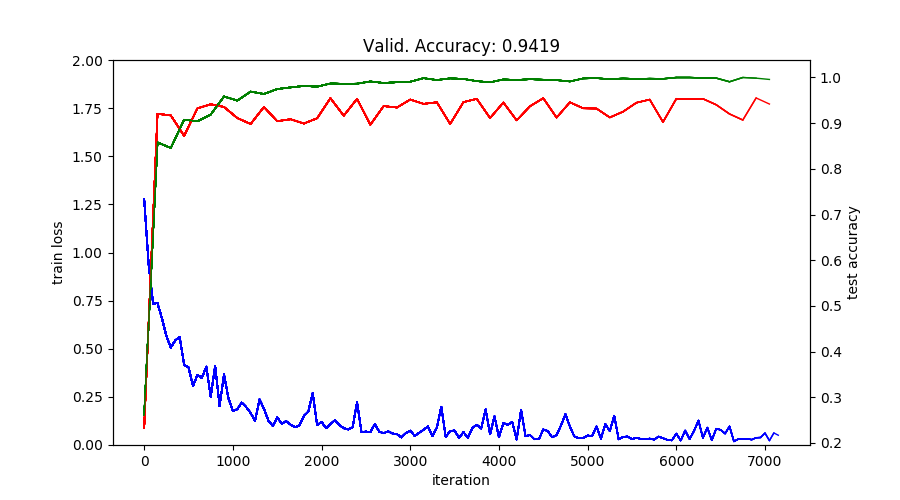

Training interrupted, model saved.
Training finished with accuracy: 0.953632


In [12]:
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

# Creat plot for live stats ploting
trainPlot = TrainingPlot(TRAIN_STEPS, TEST_ITER, LOSS_ITER)

try:
    for i_batch in range(TRAIN_STEPS):
        fd = train_iterator.next_feed(BATCH_SIZE)
        train_step.run(fd)
        
        if i_batch % LOSS_ITER == 0:
            # Plotting loss
            tmpLoss = loss.eval(fd)
            trainPlot.updateCost(tmpLoss, i_batch // LOSS_ITER)
    
        if i_batch % TEST_ITER == 0:
            # Plotting accuracy
            fd_test = test_iterator.next_feed(BATCH_SIZE)
            accTest = accuracy.eval(fd_test)
            accTrain = accuracy.eval(fd)
            trainPlot.updateAcc(accTest, accTrain, i_batch // TEST_ITER)

        if i_batch % SAVE_ITER == 0:
            saver.save(sess, save_loc)
        
except KeyboardInterrupt:
    saver.save(sess, save_loc)
    print('Training interrupted, model saved.')


fd_test = test_iterator.next_feed(2*BATCH_SIZE)
accTest = accuracy.eval(fd_test)
print("Training finished with accuracy:", accTest)